Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor


# 1. Data Cleaning and Normalization for the new dataset
def preprocess_data(df, product_name):
    """
    Preprocess data for a single product:
    - Filters product-specific data
    - Sorts by year and month (chronologically)
    - Normalizes Total_Quantity
    """

    month_order = ["January", "February", "March", "April", "May", "June",
                   "July", "August", "September", "October", "November", "December"]

    # Filter data for selected product
    product_df = df[df['Product_Name'] == product_name].copy()

    # Ensure correct month order
    product_df['Month'] = pd.Categorical(product_df['Month'], categories=month_order, ordered=True)

    # ✅ Sort by Year THEN Month
    product_df = product_df.sort_values(['Year', 'Month']).reset_index(drop=True)

    # Extract Total_Quantity as numpy array
    data = product_df['Total_Quantity'].values.reshape(-1, 1)

    # Handle missing valuesar
    data = np.nan_to_num(data)

    # Normalize between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler, product_df, data



# 2. Create supervised learning dataset USING SCALED DATA
def create_dataset(scaled_data, time_steps=12):
    """
    Creates sequences of data for LSTM input:
    - X: past time steps
    - y: next step prediction target
    """

    X, y = [], []
    for i in range(len(scaled_data) - time_steps):
        X.append(scaled_data[i:(i + time_steps), 0])  # take past demand
        y.append(scaled_data[i + time_steps, 0])      # predict next demand
    X = np.array(X)
    y = np.array(y)
    return X, y


In [2]:
# 1️⃣ Load dataset
file_path = "../data/demand_prediction_dataset.xlsx"
df = pd.read_excel(file_path)
df.head()


,Product_Name,Year,Month,Year_Month,Total_Quantity
0,Abatatriptan,2017,April,2017-April,1410.0
1,Abatatriptan,2017,August,2017-August,3349.0
2,Abatatriptan,2017,December,2017-December,866.0
3,Abatatriptan,2017,February,2017-February,452.0
4,Abatatriptan,2017,January,2017-January,2144.0


In [4]:
scaled_data, scaler, product_df , data = preprocess_data(df, "Abatatriptan")
print("scaled data",scaled_data,"/n")
print("scaler",scaler,"/n")
print(product_df)
print(data)

scaled data [[2.79230390e-01]
 [9.86679822e-04]
 [3.20506496e-01]
 [1.58526558e-01]
 [4.82486433e-01]
 [5.77207696e-02]
 [1.51126459e-01]
 [4.77388587e-01]
 [4.11609933e-01]
 [3.90231870e-01]
 [5.39878309e-01]
 [6.90675876e-02]
 [9.93257688e-02]
 [1.52770926e-01]
 [7.46587732e-01]
 [1.44548594e-01]
 [1.54415392e-01]
 [2.83670449e-01]
 [3.33497780e-01]
 [1.22183851e-01]
 [1.58526558e-01]
 [3.44680151e-01]
 [3.22315409e-02]
 [1.29912843e-02]
 [3.38760072e-02]
 [2.73968097e-01]
 [7.90659431e-01]
 [2.61470153e-02]
 [1.00000000e+00]
 [0.00000000e+00]
 [2.63279066e-01]
 [5.41522776e-01]
 [1.79411281e-01]
 [6.69297813e-02]
 [4.17365565e-01]
 [1.32215096e-01]
 [5.77701036e-01]
 [4.40223647e-01]
 [5.21953626e-01]
 [2.37954284e-01]
 [9.62012827e-02]
 [2.65910212e-01]
 [6.12234830e-01]
 [1.44713041e-02]
 [2.54234501e-01]
 [4.65383983e-02]
 [3.67538234e-01]
 [1.59513238e-02]] /n
scaler MinMaxScaler() /n
    Product_Name  Year      Month      Year_Month  Total_Quantity
0   Abatatriptan  2017    Jan

In [5]:
X, y =  create_dataset(scaled_data, time_steps=10) 
print(X,y)

[[2.79230390e-01 9.86679822e-04 3.20506496e-01 1.58526558e-01
  4.82486433e-01 5.77207696e-02 1.51126459e-01 4.77388587e-01
  4.11609933e-01 3.90231870e-01]
 [9.86679822e-04 3.20506496e-01 1.58526558e-01 4.82486433e-01
  5.77207696e-02 1.51126459e-01 4.77388587e-01 4.11609933e-01
  3.90231870e-01 5.39878309e-01]
 [3.20506496e-01 1.58526558e-01 4.82486433e-01 5.77207696e-02
  1.51126459e-01 4.77388587e-01 4.11609933e-01 3.90231870e-01
  5.39878309e-01 6.90675876e-02]
 [1.58526558e-01 4.82486433e-01 5.77207696e-02 1.51126459e-01
  4.77388587e-01 4.11609933e-01 3.90231870e-01 5.39878309e-01
  6.90675876e-02 9.93257688e-02]
 [4.82486433e-01 5.77207696e-02 1.51126459e-01 4.77388587e-01
  4.11609933e-01 3.90231870e-01 5.39878309e-01 6.90675876e-02
  9.93257688e-02 1.52770926e-01]
 [5.77207696e-02 1.51126459e-01 4.77388587e-01 4.11609933e-01
  3.90231870e-01 5.39878309e-01 6.90675876e-02 9.93257688e-02
  1.52770926e-01 7.46587732e-01]
 [1.51126459e-01 4.77388587e-01 4.11609933e-01 3.90231870e

In [6]:
print("Scaled data sample:", scaled_data[:10].flatten())
print("X sample:", X[0])
print("y sample:", y[0])
print("Original demand sample:", data[:10].flatten())


Scaled data sample: [0.27923039 0.00098668 0.3205065  0.15852656 0.48248643 0.05772077
 0.15112646 0.47738859 0.41160993 0.39023187]
X sample: [0.27923039 0.00098668 0.3205065  0.15852656 0.48248643 0.05772077
 0.15112646 0.47738859 0.41160993 0.39023187]
y sample: 0.5398783094885711
Original demand sample: [2144.  452. 2395. 1410. 3380.  797. 1365. 3349. 2949. 2819.]


In [7]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print(len(X))
print(X)

38
[[[2.79230390e-01]
  [9.86679822e-04]
  [3.20506496e-01]
  [1.58526558e-01]
  [4.82486433e-01]
  [5.77207696e-02]
  [1.51126459e-01]
  [4.77388587e-01]
  [4.11609933e-01]
  [3.90231870e-01]]

 [[9.86679822e-04]
  [3.20506496e-01]
  [1.58526558e-01]
  [4.82486433e-01]
  [5.77207696e-02]
  [1.51126459e-01]
  [4.77388587e-01]
  [4.11609933e-01]
  [3.90231870e-01]
  [5.39878309e-01]]

 [[3.20506496e-01]
  [1.58526558e-01]
  [4.82486433e-01]
  [5.77207696e-02]
  [1.51126459e-01]
  [4.77388587e-01]
  [4.11609933e-01]
  [3.90231870e-01]
  [5.39878309e-01]
  [6.90675876e-02]]

 [[1.58526558e-01]
  [4.82486433e-01]
  [5.77207696e-02]
  [1.51126459e-01]
  [4.77388587e-01]
  [4.11609933e-01]
  [3.90231870e-01]
  [5.39878309e-01]
  [6.90675876e-02]
  [9.93257688e-02]]

 [[4.82486433e-01]
  [5.77207696e-02]
  [1.51126459e-01]
  [4.77388587e-01]
  [4.11609933e-01]
  [3.90231870e-01]
  [5.39878309e-01]
  [6.90675876e-02]
  [9.93257688e-02]
  [1.52770926e-01]]

 [[5.77207696e-02]
  [1.51126459e-01]

Model Architecture Implementation

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, Adamax, Nadam

In [9]:
def create_multilayer_lstm_model(units=64, dropout_rate=0.2, activation='relu', 
                                optimizer='adam', time_steps=10):
    """
    Build the multilayer LSTM model as described in the paper
    """
    model = Sequential()

    # Define the input layer explicitly
    model.add(Input(shape=(time_steps, 1)))
    
    # First LSTM layer with return_sequences=True for multilayer
    model.add(LSTM(units=units, 
                   return_sequences=True, 
                   #input_shape=(time_steps, 1),
                   activation=activation))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer (final layer with return_sequences=False)
    model.add(LSTM(units=units, 
                   activation=activation))
    model.add(Dropout(dropout_rate))
    
    # Dense output layer
    model.add(Dense(units=1))
    
     # Choose optimizer
    optimizer_dict = {
        'Adam': Adam(),
        'Adagrad': Adagrad(),
        'Adadelta': Adadelta(),
        'Adamax': Adamax(),
        'Nadam': Nadam()
    }

    
    # Compile model with MSE loss as mentioned in paper
    model.compile(optimizer=optimizer, loss='mse')
    
    return model


Evaluation Metrics

In [10]:
def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate using RMSE and SMAPE as in the paper
    """
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate RMSE (equation 13)
    rmse = np.sqrt(np.mean((y_test_actual - predictions) ** 2))
    
    # Calculate SMAPE (equation 12)
    smape = np.mean(2 * np.abs(y_test_actual - predictions) / 
                   (np.abs(y_test_actual) + np.abs(predictions)))
    
    return rmse, smape, predictions, y_test_actual


Complete Training Pipeline

In [21]:
def train_pharmaceutical_lstm(sales_data, product_to_be_predicted):
    """
    Complete training pipeline following the paper's methodology
    """
    # Step 1: Preprocess data
    scaled_data, scaler, product_df, data = preprocess_data(sales_data, product_to_be_predicted)

    
    # Step 2: Create supervised learning dataset
    X, y = create_dataset(scaled_data, time_steps=12)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Step 3: Split data as described in paper
    # Training: Jan 2012 - July 2017
    # Testing: Aug 2017 - March 2019  
    # Validation: April 2019 - Dec 2020
    
    train_size = int(0.7 * len(X))
    test_size = int(0.85 * len(X))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:test_size], y[train_size:test_size]
    X_val, y_val = X[test_size:], y[test_size:]
    
    # Reshape for LSTM input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    # Step 4: Build optimized model using best parameters from paper
    model = create_multilayer_lstm_model(
        units=64,
        dropout_rate=0.0,  # Best parameter from their grid search
        activation='relu',  # You may need to test this
        optimizer='Adam',
        time_steps=12
    )
    
    # Step 5: Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=2,
        validation_data=(X_val, y_val),
        verbose=1,
        shuffle=False
    )

    rmse, smape, predictions, y_test_actual = evaluate_model(model, X_test, y_test, scaler)

    return model, scaler, history, rmse, smape, predictions, y_test_actual, X, y


train and plot demand forecasting

Available Medicines:
 ['Abatatriptan' 'Abilovir Aprotasol' 'Abobozolid' 'Abranatal Lysoprosate'
 'Abtasol' 'Acantaine' 'Acelimus' 'Aciprex' 'Aclonuma' 'Acubulin'
 'Acycnafine Microvate' 'Acycpex' 'Adalatamine' 'Adideine'
 'Adrecetam Barazoxane' 'Adriacaine' 'Adriafinil Ehtymara'
 'Adtiza Gammaluble' 'Afaxacin' 'Afinitasol' 'Afluferon Entrarenone'
 'Afretosine' 'Agalsiline' 'Aggrakine' 'Aggretisol' 'Alarudin Azarolac'
 'Albudazole Erobloc' 'Albuterenone' 'Aldevac' 'Alemtuvatol Megalinum'
 'Algluconium Dorzofoxin' 'Alglutriptan' 'Alimmethate Insudase'
 'Alisteride Pemidizem' 'Allomenda' 'Alpharolac' 'Alpradipine' 'Amamadin'
 'Amavirase' 'Amcibax Amcikeran' 'Amlominphen Dexanovate' 'Amphesirox'
 'Ampinonide' 'Ampysin' 'Androporin' 'Angioparin Brimosumab'
 'Antaparin Varizyme' 'Antilamin Clinbital' 'Aprerase' 'Apromin'
 'Apronazol' 'Aquamycin Lacoran' 'Araxetine' 'Argalazine Abostryl'
 'Arivac' 'Asparathasone Unipan' 'Aspinavir Silovance' 'Atomorelin'
 'Atrabicin Alkerotec' 'Belavarix Benz

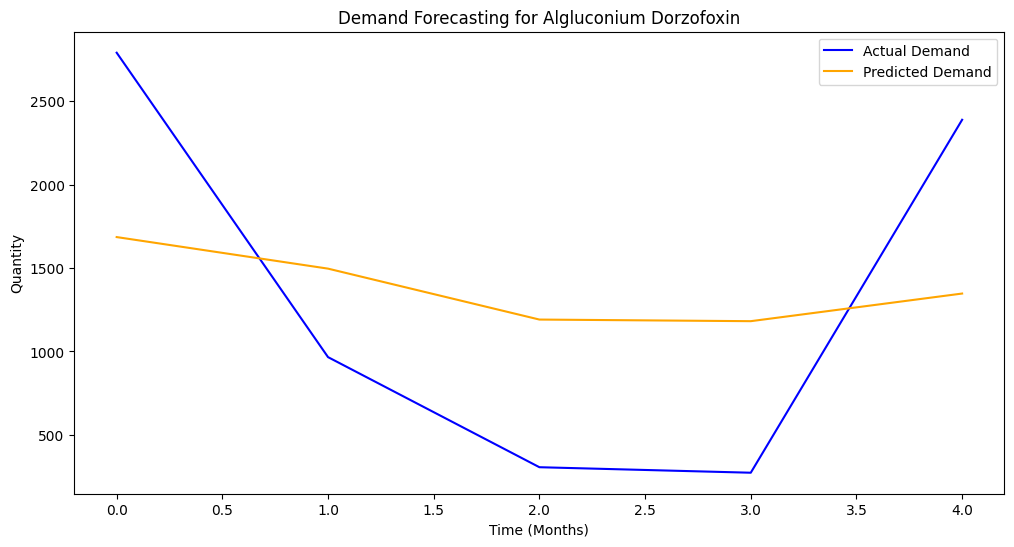

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


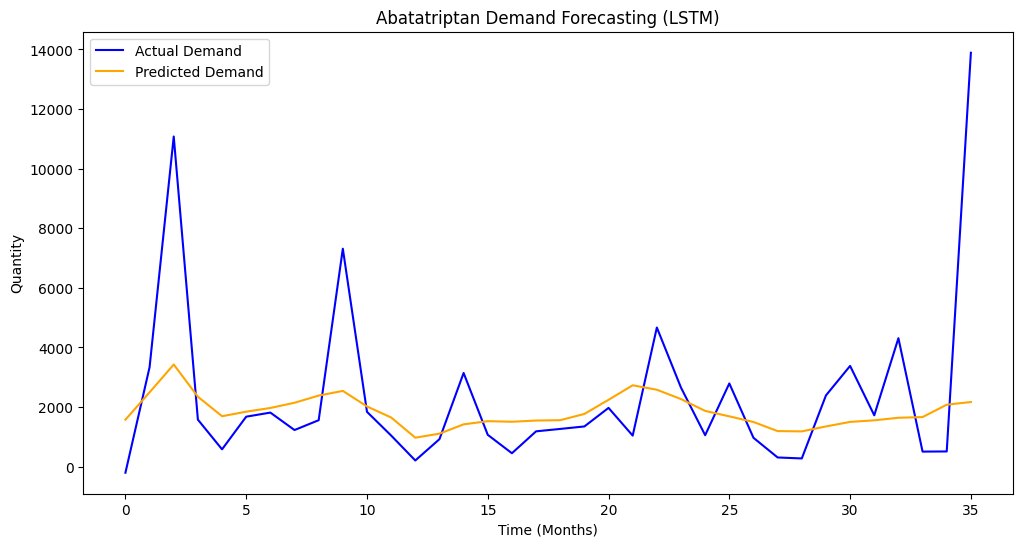

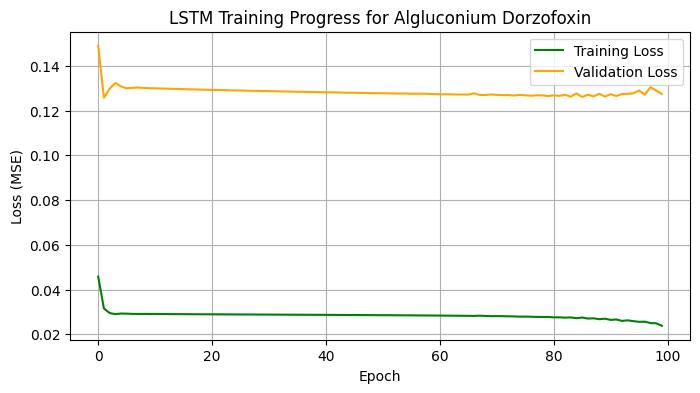

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load dataset
file_path = "../data/demand_prediction_dataset.xlsx"
sales_data = pd.read_excel(file_path)

# 2️⃣ Display available medicines
unique_medicines = sales_data['Product_Name'].unique()
print("Available Medicines:\n", unique_medicines)

# 3️⃣ Select medicine dynamically
selected_medicine = input("Enter the medicine name from the list above: ")

# 4️⃣ Train LSTM model (includes preprocessing + evaluation internally)
model, scaler, history, rmse, smape, predictions, y_test_actual, X, y = train_pharmaceutical_lstm(
    sales_data, selected_medicine
)

# 5️⃣ Print model performance
print(f"\n📊 Model Evaluation for {selected_medicine}")
print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape:.2%}")


# 6️⃣ Plot Actual vs Predicted Demand
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Demand', color='blue')
plt.plot(predictions, label='Predicted Demand', color='orange')
plt.title(f"Demand Forecasting for {selected_medicine}")
plt.xlabel("Time (Months)")
plt.ylabel("Quantity")
plt.legend()
plt.show()


predictions1 = scaler.inverse_transform(model.predict(X))
y1 = scaler.inverse_transform(y.reshape(-1, 1))

# Plot actual vs predicted demand ON WHOLE DATA
plt.figure(figsize=(12,6))
plt.plot(y1, label='Actual Demand', color='blue')
plt.plot(predictions1, label='Predicted Demand', color='orange')
plt.title("Abatatriptan Demand Forecasting (LSTM)") 
plt.xlabel("Time (Months)")
plt.ylabel("Quantity")
plt.legend()
plt.show()

# 7️⃣ Plot Training & Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title(f"LSTM Training Progress for {selected_medicine}")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


Grid Search Implementation

In [ ]:
def build_optimized_lstm():
    """
    Implement grid search as described in the methodology
    """
    # Grid search parameters from Table 2
    param_grid = {
    'units': [64],
    'dropout_rate': [0.2, 0.3],
    'activation': ['relu', 'tanh'],
    'batch_size': [16, 32],
    'epochs': [50],
    'optimizer': ['Adam', 'Nadam']
    }


    """
    param_grid = {
        'units': [64],  # Paper used 64 units
        'dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'activation': ['relu', 'tanh', 'sigmoid', 'hard_sigmoid'],
        'batch_size': [8, 16, 32, 48],
        'epochs': [50, 100, 130, 150, 200, 250],
        'optimizer': ['Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    }
    """

    # Create KerasRegressor wrapper
    model = KerasRegressor(
        build_fn=create_multilayer_lstm_model,
        verbose=0
    )
    
    # Perform grid search
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    return grid
